# Principal Component Analysis of the Biolog Data
## 606 linage

After processing the data according to our normalization and filtering protocol, we perform dimensionality reduction using PCA.

In [1]:
#Libraries
import julia
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
import sys
from pylab import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import os 

#Functions
def talus(singular):
    talo=[]
    for i in range(0,len(singular)-2):
        value=log(singular[i])-log(singular[i+1])
        talo.append(value)
    return talo

First, we will look at the data of the clones derived from the ancestral population for both linages.

In [2]:
#Load the data
name="normalized606Wells86&94RemovedUncenteredFinalBiologData.csv"
df=pd.read_csv(name)
#Remove negative values
num = df._get_numeric_data()
num[num < 0] = 0
#Annotations
temperature = df.Condition.values #Or any other factor
strain = df.Strain.values
labels = df.Replicate.values
biolog=pd.read_csv("gen_biolog .csv")
dictbio=biolog.set_index('Well').to_dict()
df.columns=df.columns.to_series().map(dictbio['Assay'])

In [3]:
#Values for the PCA
data=df.iloc[:,5:]
X = df.iloc[:,5:].values
#To log transform with an offset
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=False)
X=transformer.transform(X)

Given the talus plot, we can see that the variability of our data is mostly explained with 7 principal components.

<IPython.core.display.Javascript object>


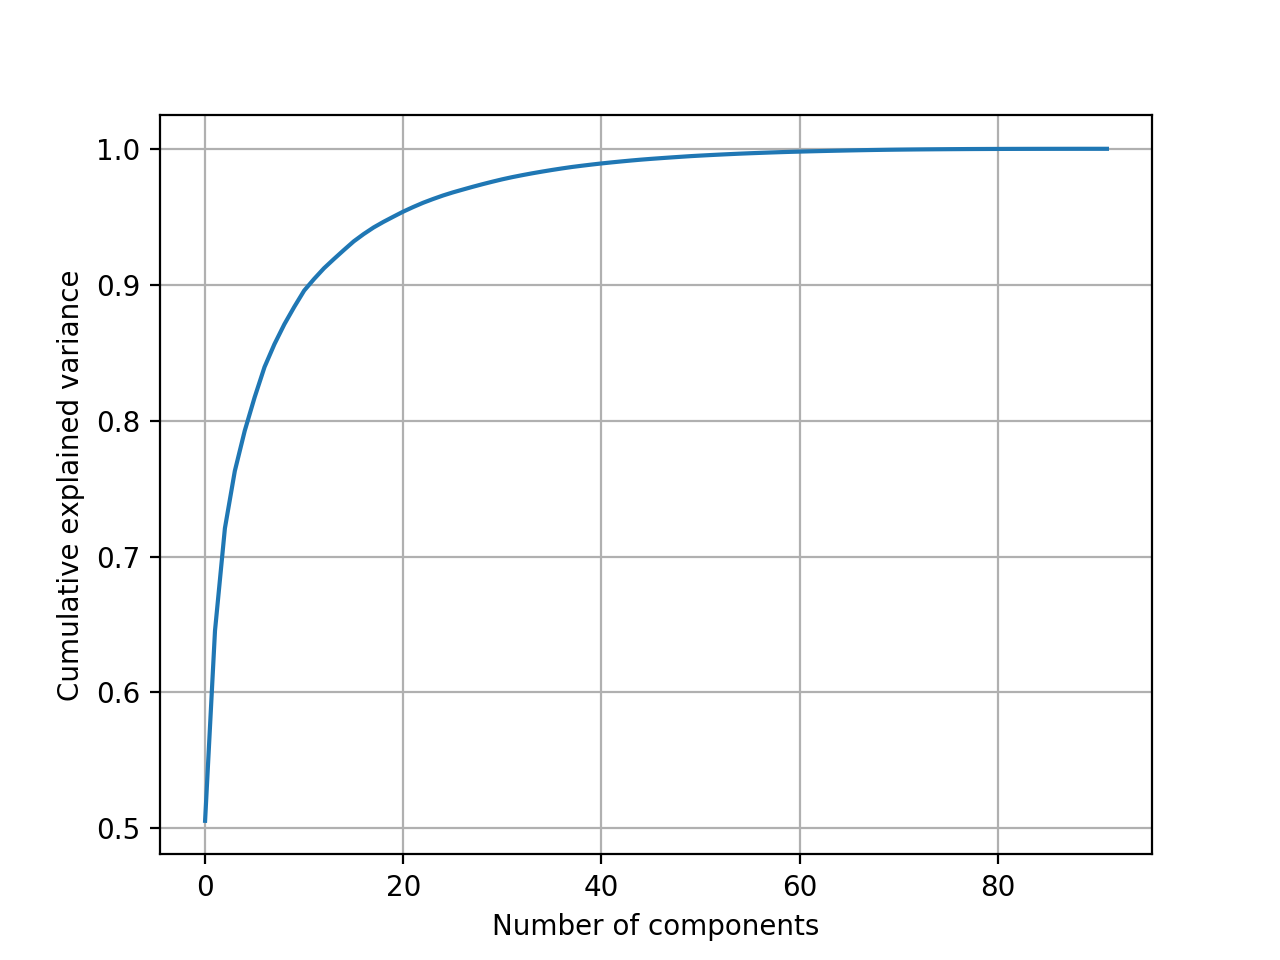

In [4]:
%matplotlib notebook
#PCA
pca = PCA()
X_reduced = pca.fit_transform(scale(X,with_std=False))
#Variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.grid();
#plt.xticks(np.arange(0, 50, step=2));
PC1_v=round(100*pca.explained_variance_ratio_[0],1)
PC2_v=round(100*pca.explained_variance_ratio_[1],1)
PC3_v=round(100*pca.explained_variance_ratio_[2],1)
PC4_v=round(100*pca.explained_variance_ratio_[3],1)
PC5_v=round(100*pca.explained_variance_ratio_[4],1)

In [5]:
#Get the ancestral values
X_ancestor=X_reduced[0:17,:]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_ancestor)
# Get the cluster centroids
centers = kmeans.cluster_centers_

<IPython.core.display.Javascript object>


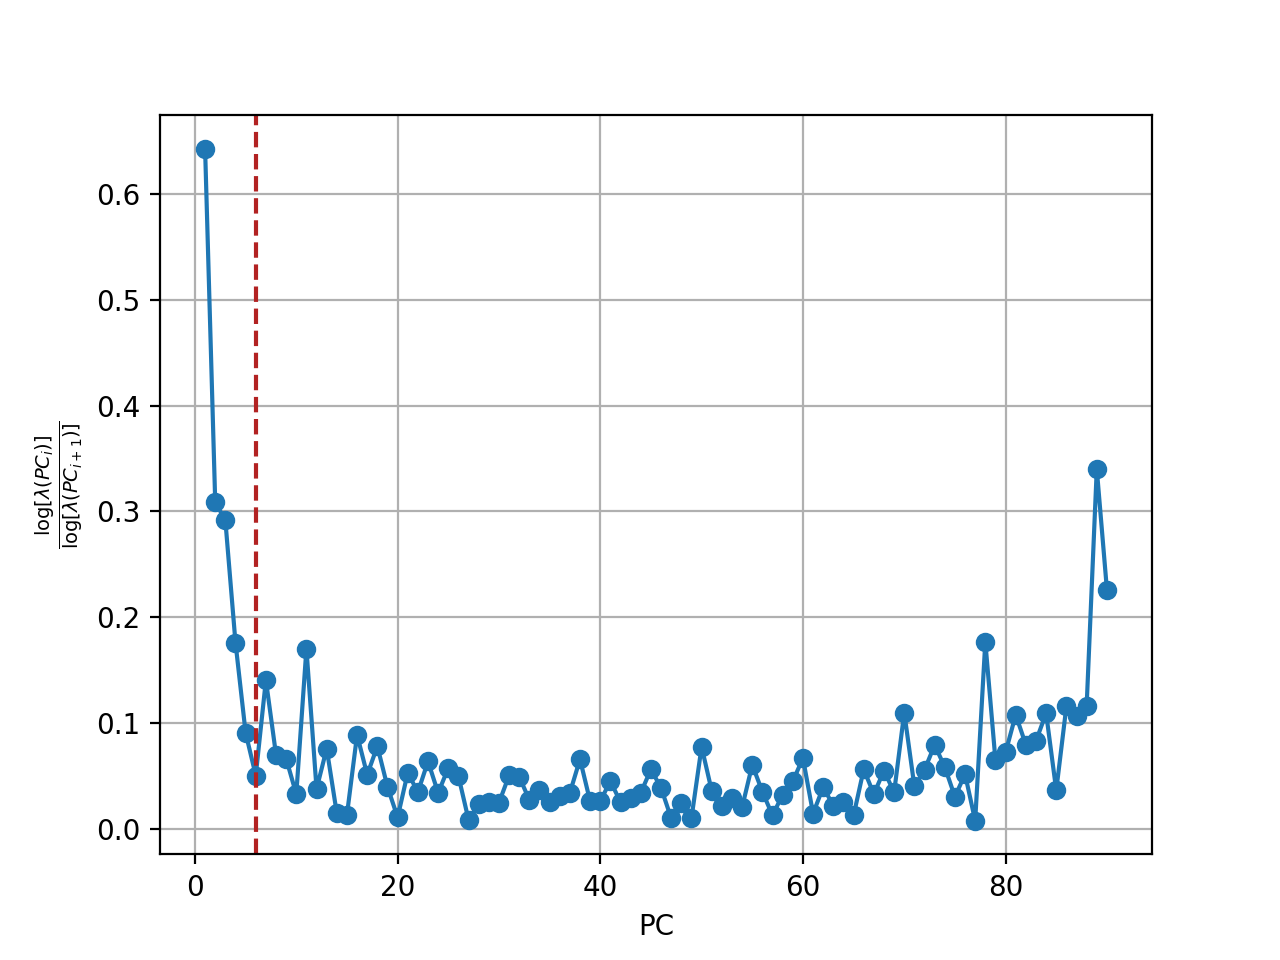

In [7]:
%matplotlib notebook
#Talus Plot
tal=talus(pca.singular_values_)
plot(np.arange(1,91),tal,'o-')
plt.xlabel('PC')
plt.ylabel(r"$\frac{\log\left[{\lambda\left(PC_i\right)}\right]}{\log\left[{\lambda\left(PC_{i+1}\right)}\right]}$");
plt.grid();
#plt.xticks(np.arange(1, 32, step=2));
plt.axvline(x=6, linestyle = '--', color = 'firebrick')
#Save
pp = PdfPages('606_talus.pdf')
plt.savefig(pp,format='pdf')
pp.close()


We will first inspect the first three principal components.

<IPython.core.display.Javascript object>


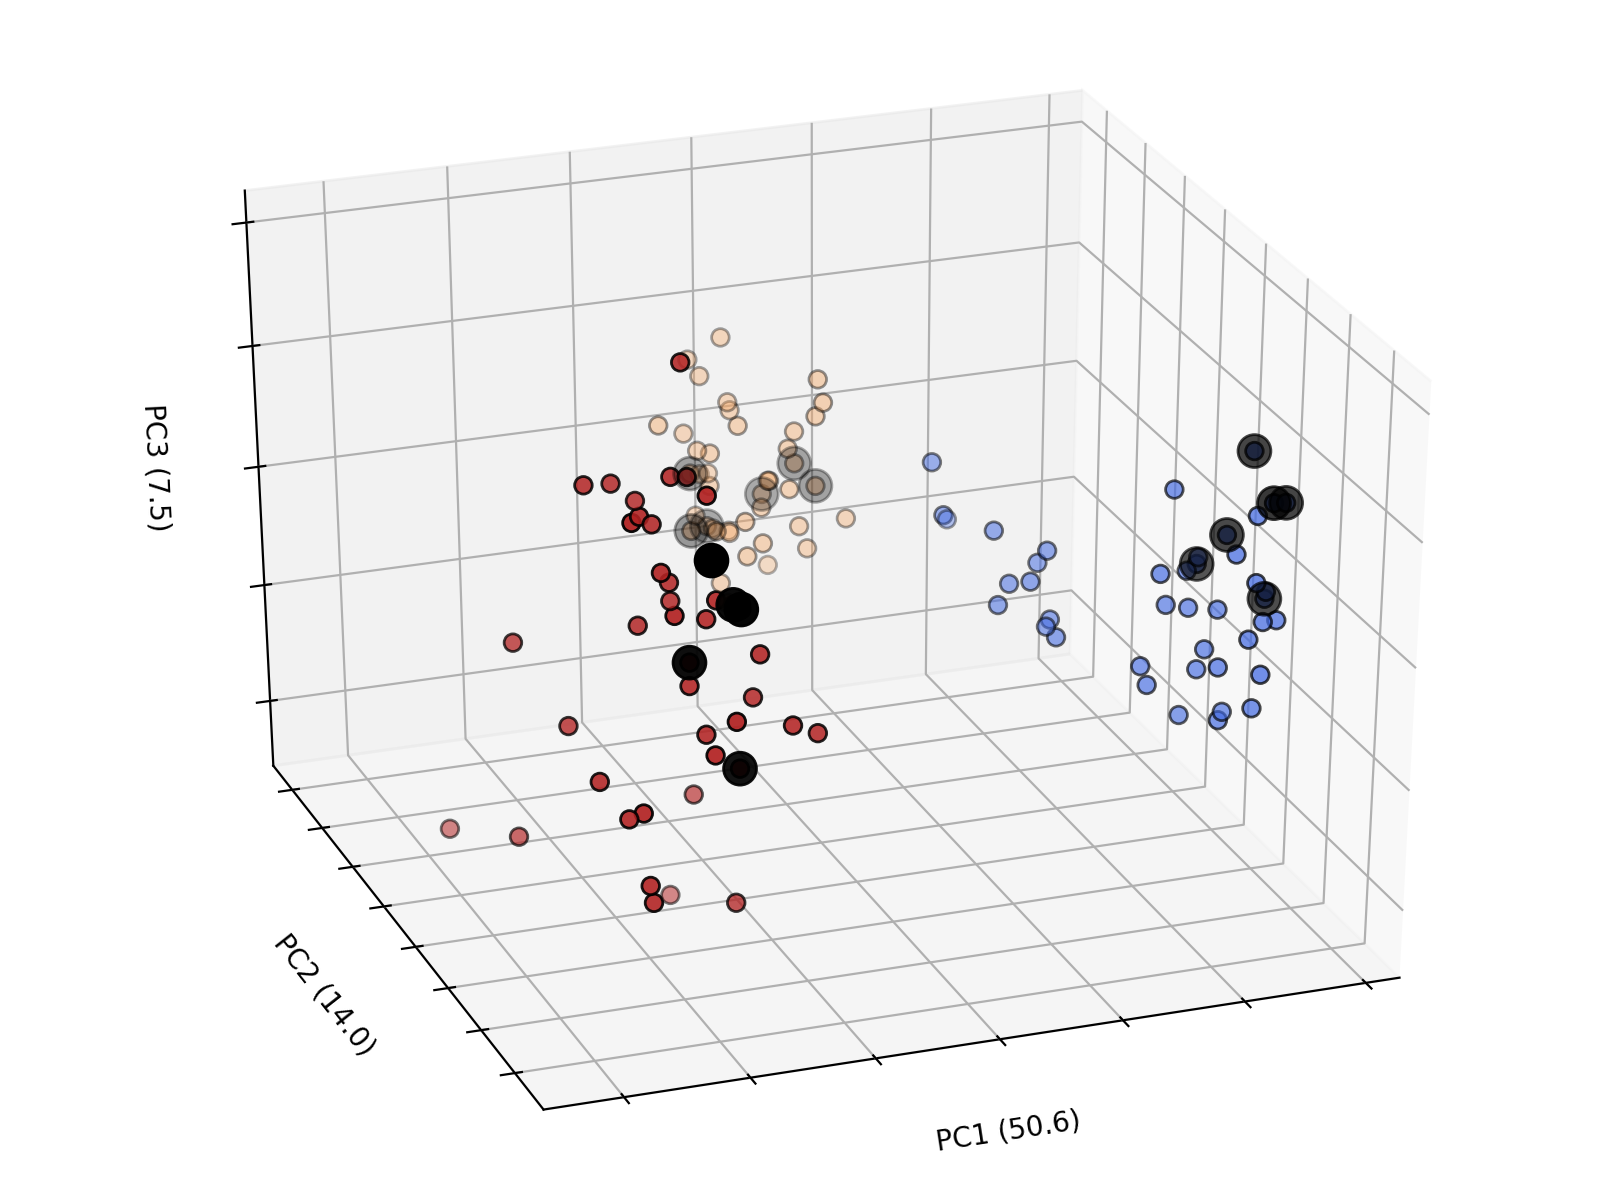

In [13]:
%matplotlib notebook
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
#Color by factor
colors1 = ['royalblue','sandybrown', 'firebrick']
y1= pd.Series(temperature, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=colors,
          cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_xlabel("PC1 ({})".format(PC1_v))
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2 ({})".format(PC2_v))
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3 ({})".format(PC3_v))
ax.w_zaxis.set_ticklabels([])


#Add ancestral
ax.scatter(X_ancestor[:, 0], X_ancestor[:, 1],X_ancestor[:, 2], color='black', edgecolor='k',s=140, marker='o')
#Save
pp = PdfPages('606_3D.pdf')
plt.savefig(pp,format='pdf')
pp.close()

The samples are separated well by both temperature and strain.

<IPython.core.display.Javascript object>


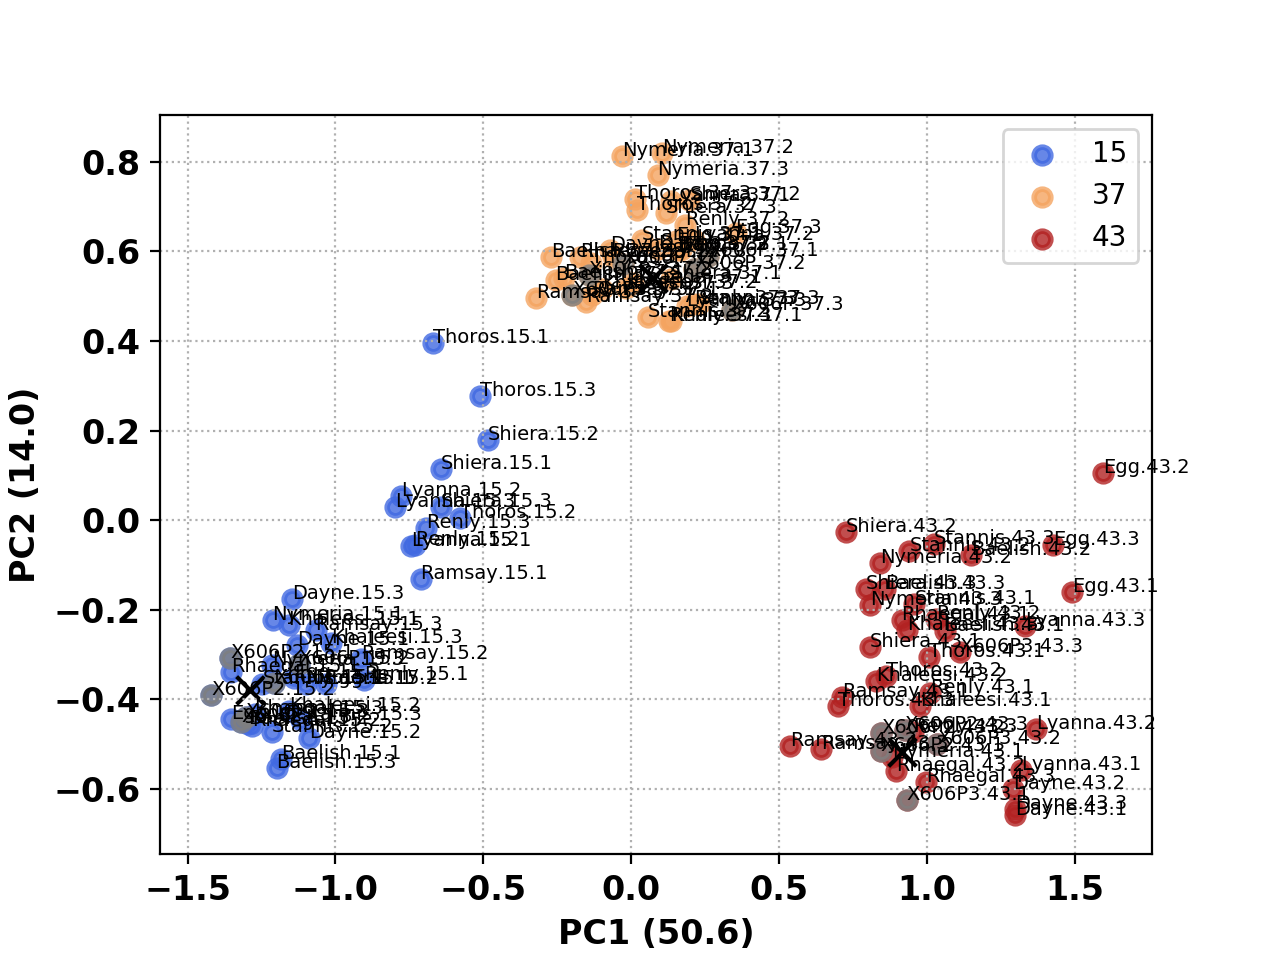

In [22]:
%matplotlib notebook
# 2D PCA
ig, ax = plt.subplots()
colors = ['royalblue', 'sandybrown', 'firebrick']
lw = 2
conditions=unique(temperature)


for color, i, conditions in zip(colors, [15, 37, 43], conditions):
    plt.scatter(X_reduced[temperature == i, 0], X_reduced[temperature == i, 1], color=color, alpha=.8, lw=lw,
                label=conditions)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(linestyle='dotted')

# Overlay the centroids on the scatter plot
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100,marker='x')
ax.set_xlabel("PC1 ({})".format(PC1_v),fontsize=12, fontweight='bold')
ax.set_ylabel("PC2 ({})".format(PC2_v),fontsize=12, fontweight='bold')
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
     tick.label1.set_fontsize(fontsize)
     tick.label1.set_fontweight('bold')

#For Labels
for label, x, y in zip(labels, X_reduced[:, 0], X_reduced[:, 1]):
	plt.annotate(
		label,
		xy=(x, y),
       textcoords='data',fontsize=7)

#Add ancestral
plt.scatter(X_ancestor[:, 0], X_ancestor[:, 1], color='grey', alpha=.8, lw=lw)

#Save
pp = PdfPages('606_2D.pdf')
plt.savefig(pp,format='pdf')
pp.close()

PC1 separates the three temperatures, PC2 separates the perturbed temperatures from the optimal. PC5 seems to distinguish evolved from ancestral.

In [11]:
%%capture
#Plot all components
components=pd.DataFrame(X_reduced[:,0:12])
variables=df.iloc[:,0:5]
variables=variables.reset_index()
projected = pd.concat([variables, components], axis=1)
projected['Condition'] = projected['Condition'].astype('category')
projected['Strain'] = projected['Strain'].astype('category')
projected['Treatment'] = projected['Treatment'].astype('category')
projected['Evolved'] = projected['Evolved'].astype('category')
projected=projected.drop(columns=['index'])

#Save
g = sns.pairplot(projected, hue="Treatment",diag_kind='hist')
pp = PdfPages('606_all_treat.pdf')
plt.savefig(pp,format='pdf')
pp.close()       

PC2 separtes the optimal from the new environmental conditions.

<IPython.core.display.Javascript object>


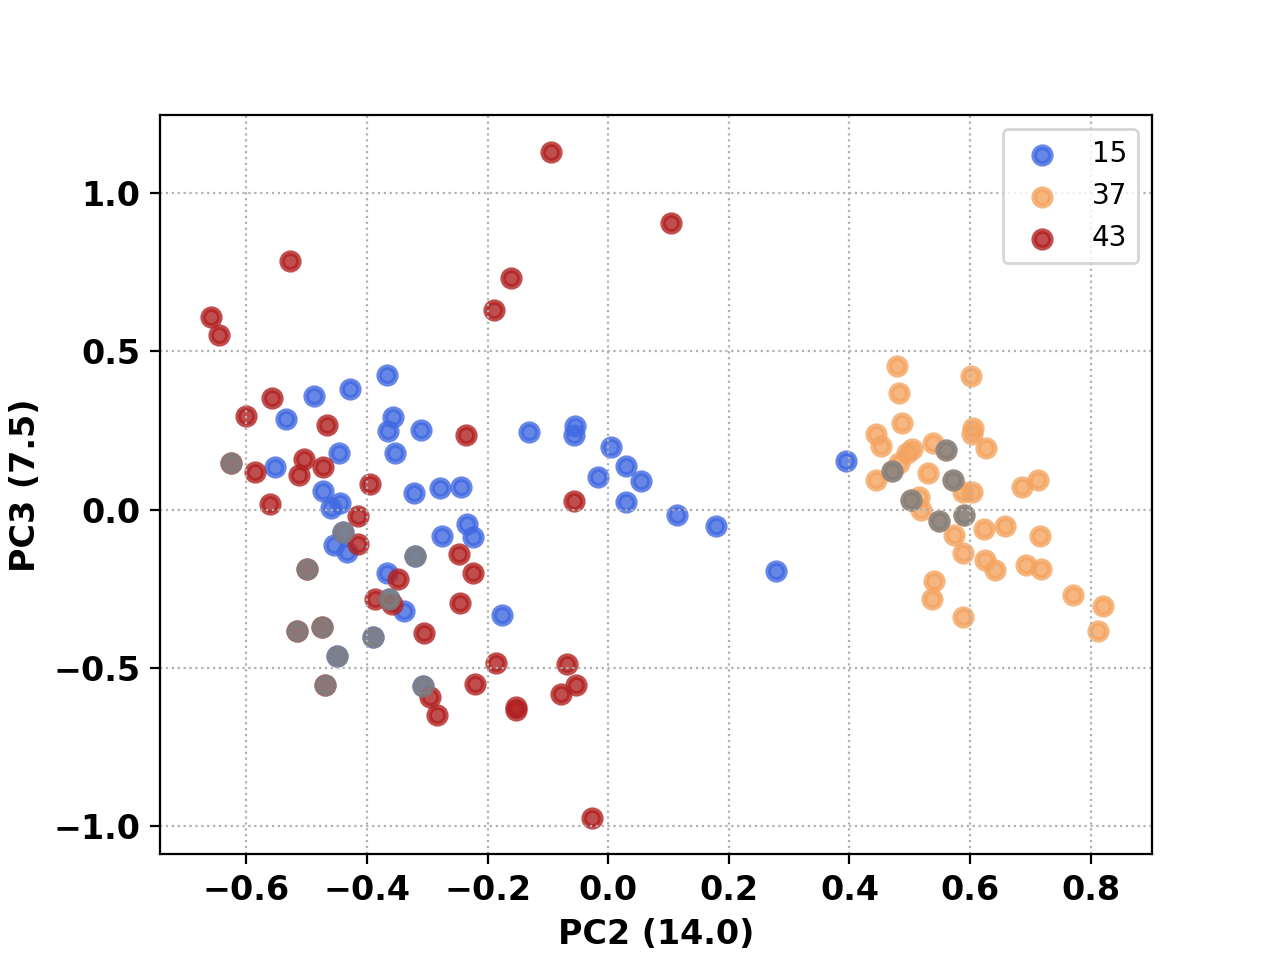

In [10]:
%matplotlib notebook
# Create 3 different clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_reduced)
# Get the cluster centroids
centers = kmeans.cluster_centers_

# 2D PCA
ig, ax = plt.subplots()
colors = ['royalblue', 'sandybrown', 'firebrick']
lw = 2
conditions=unique(temperature)


for color, i, conditions in zip(colors, [15, 37, 43], conditions):
    plt.scatter(X_reduced[temperature == i, 1], X_reduced[temperature == i, 2], color=color, alpha=.8, lw=lw,
                label=conditions)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(linestyle='dotted')

# Overlay the centroids on the scatter plot
ax.set_xlabel("PC2 ({})".format(PC2_v),fontsize=12, fontweight='bold')
ax.set_ylabel("PC3 ({})".format(PC3_v),fontsize=12, fontweight='bold')
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
     tick.label1.set_fontsize(fontsize)
     tick.label1.set_fontweight('bold')
    
#Add ancestral
plt.scatter(X_ancestor[:, 1], X_ancestor[:, 2], color='grey', alpha=.8, lw=lw)

pp = PdfPages('606_PC2.pdf')
plt.savefig(pp,format='pdf')
pp.close()

<IPython.core.display.Javascript object>


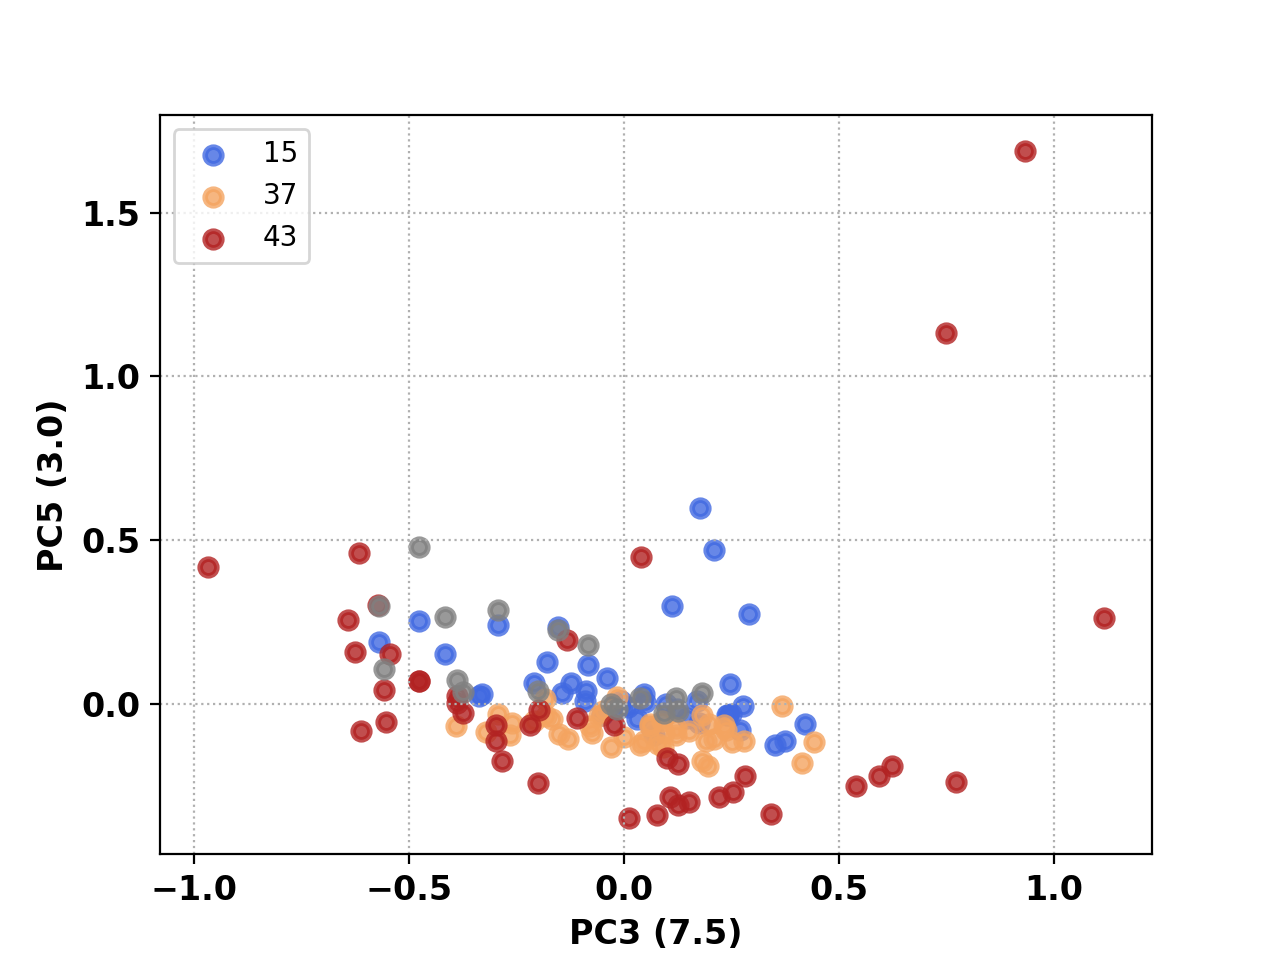

In [19]:
%matplotlib notebook
# Create 3 different clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_reduced)
# Get the cluster centroids
centers = kmeans.cluster_centers_

# 2D PCA
ig, ax = plt.subplots()
colors = ['royalblue', 'sandybrown', 'firebrick']
lw = 2
conditions=unique(temperature)


for color, i, conditions in zip(colors, [15, 37, 43], conditions):
    plt.scatter(X_reduced[temperature == i, 2], X_reduced[temperature == i, 3], color=color, alpha=.8, lw=lw,
                label=conditions)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(linestyle='dotted')

# Overlay the centroids on the scatter plot
ax.set_xlabel("PC3 ({})".format(PC3_v),fontsize=12, fontweight='bold')
ax.set_ylabel("PC5 ({})".format(PC5_v),fontsize=12, fontweight='bold')
fontsize = 12
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
     tick.label1.set_fontsize(fontsize)
     tick.label1.set_fontweight('bold')
#Add ancestral
plt.scatter(X_ancestor[:, 2], X_ancestor[:, 4], color='grey', alpha=.8, lw=lw)

<IPython.core.display.Javascript object>


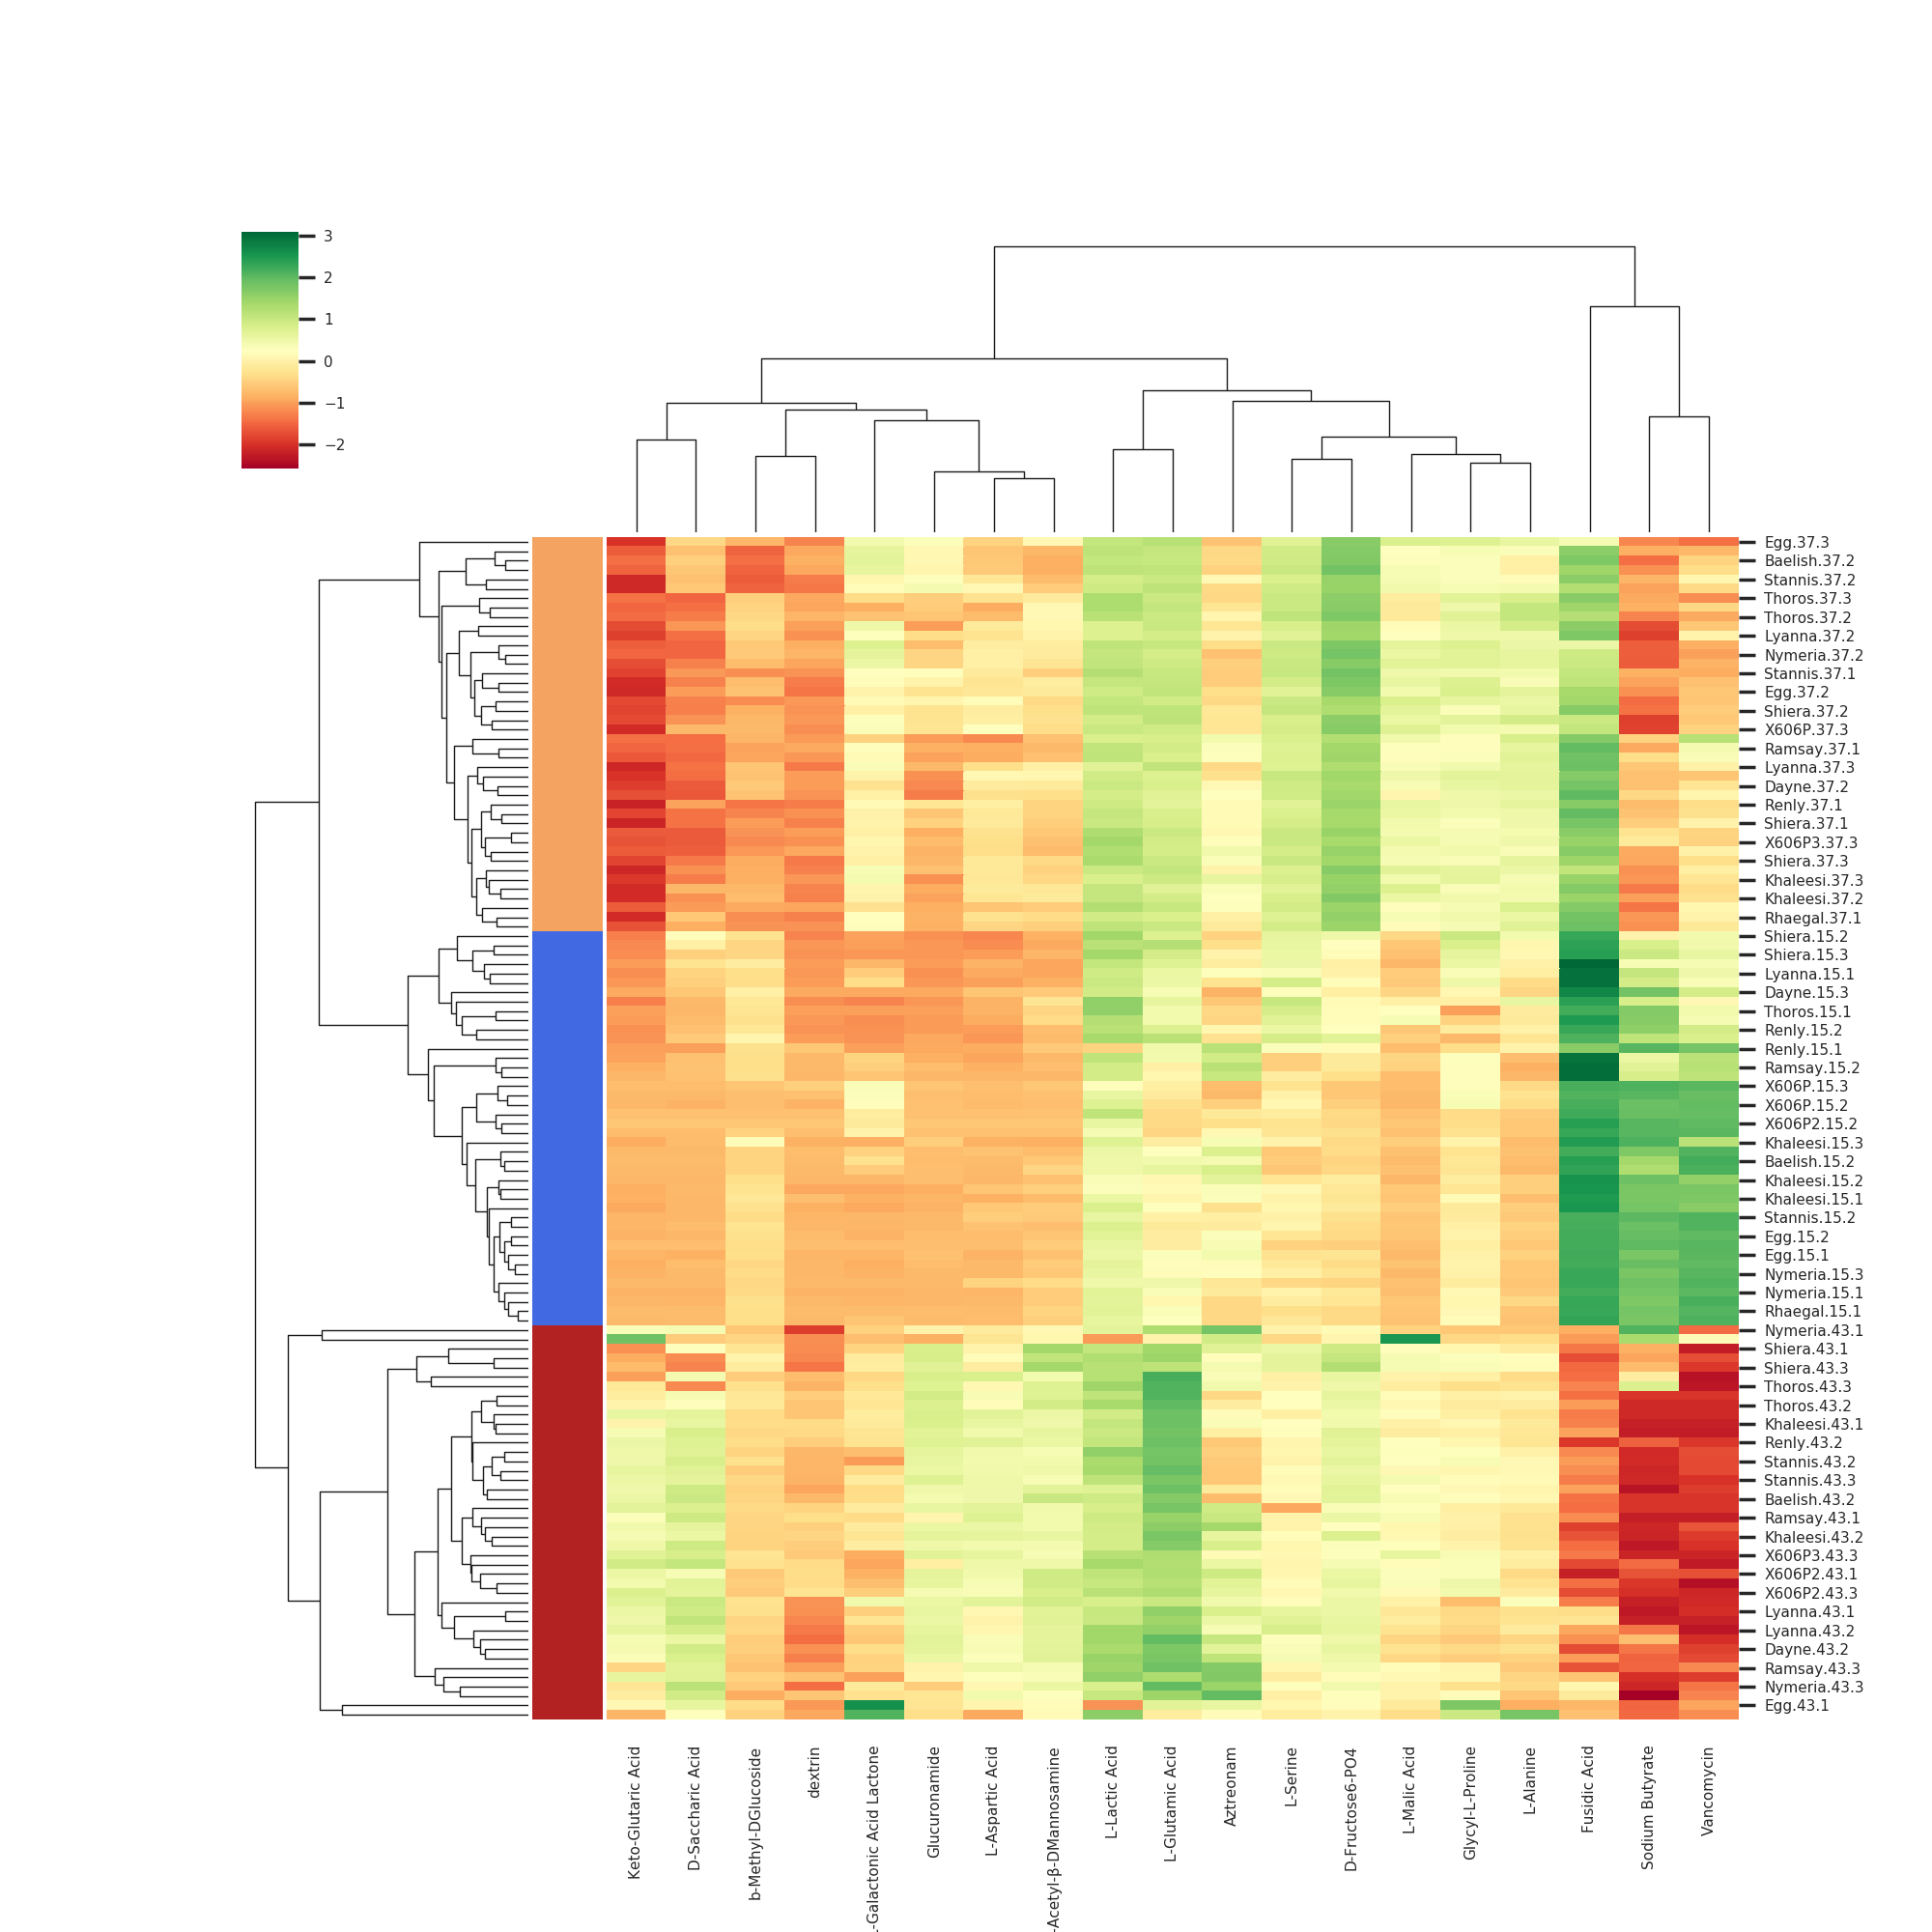

In [20]:
%matplotlib notebook
#Inspect each PC and look at the top wells, cluster them and inspect treatment
loadings = np.absolute(pca.components_)
percent=int(floor(0.8*len(loadings[0])))
order=np.argsort(loadings[0])
pc1=data.iloc[:,order[percent:len(loadings[0])]]
pc1=pc1.set_index(labels)
#Color by factor
colors1 = ['royalblue', 'sandybrown', 'firebrick']
y1= pd.Series(temperature, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)
#We can see how these variables effectively cluster our data
sns.set(font_scale=0.5) 
sns.clustermap(pc1,cmap="RdYlGn",row_colors=colors.values,z_score=0)
#Save
pp = PdfPages('pc1_clust_606.pdf')
plt.savefig(pp,format='pdf')
pp.close()

<IPython.core.display.Javascript object>


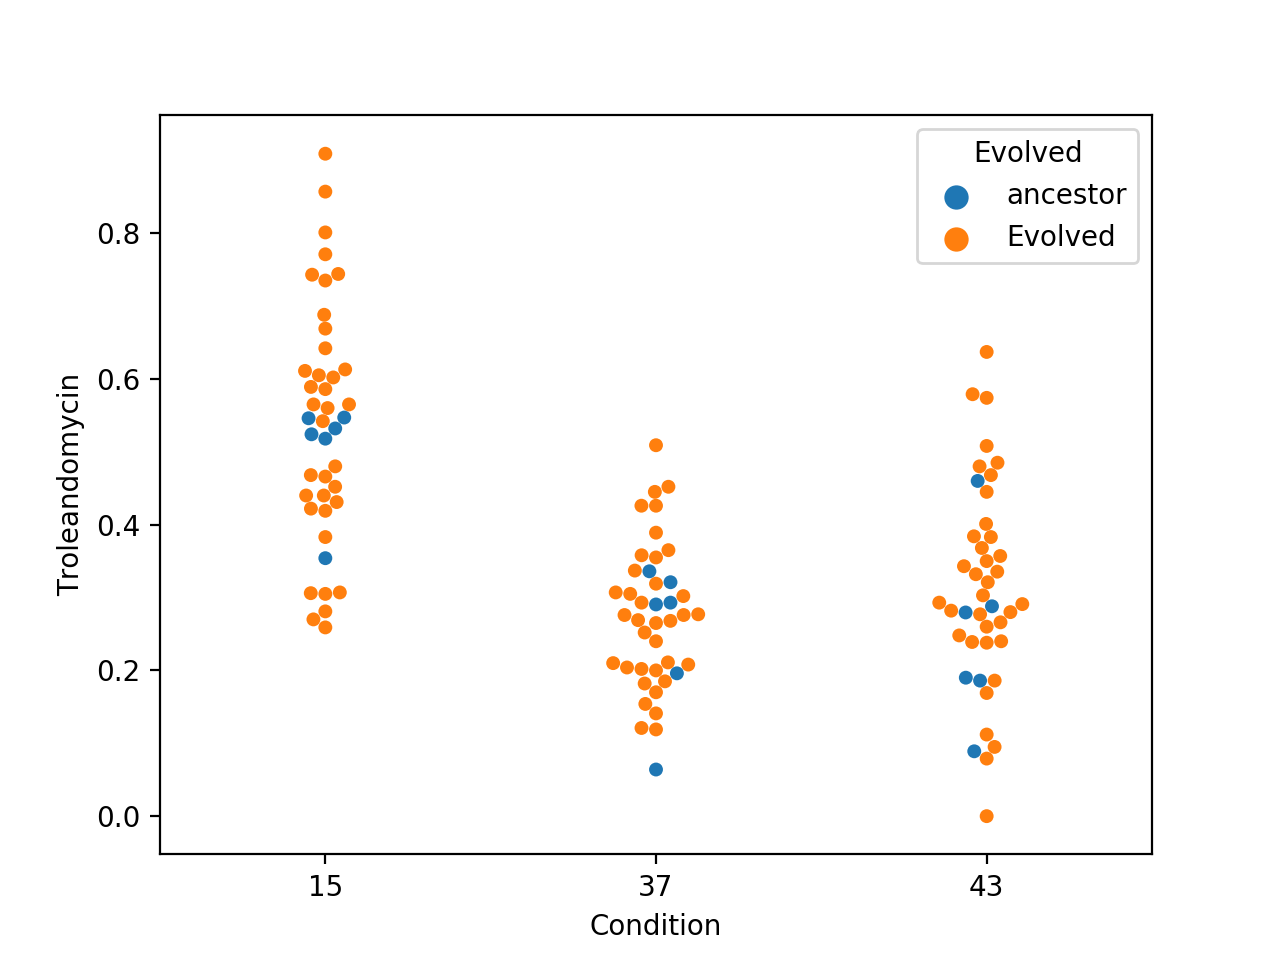

In [32]:
%matplotlib notebook
sns.swarmplot(x='Condition',y='Troleandomycin', hue='Evolved',data=df)


<IPython.core.display.Javascript object>


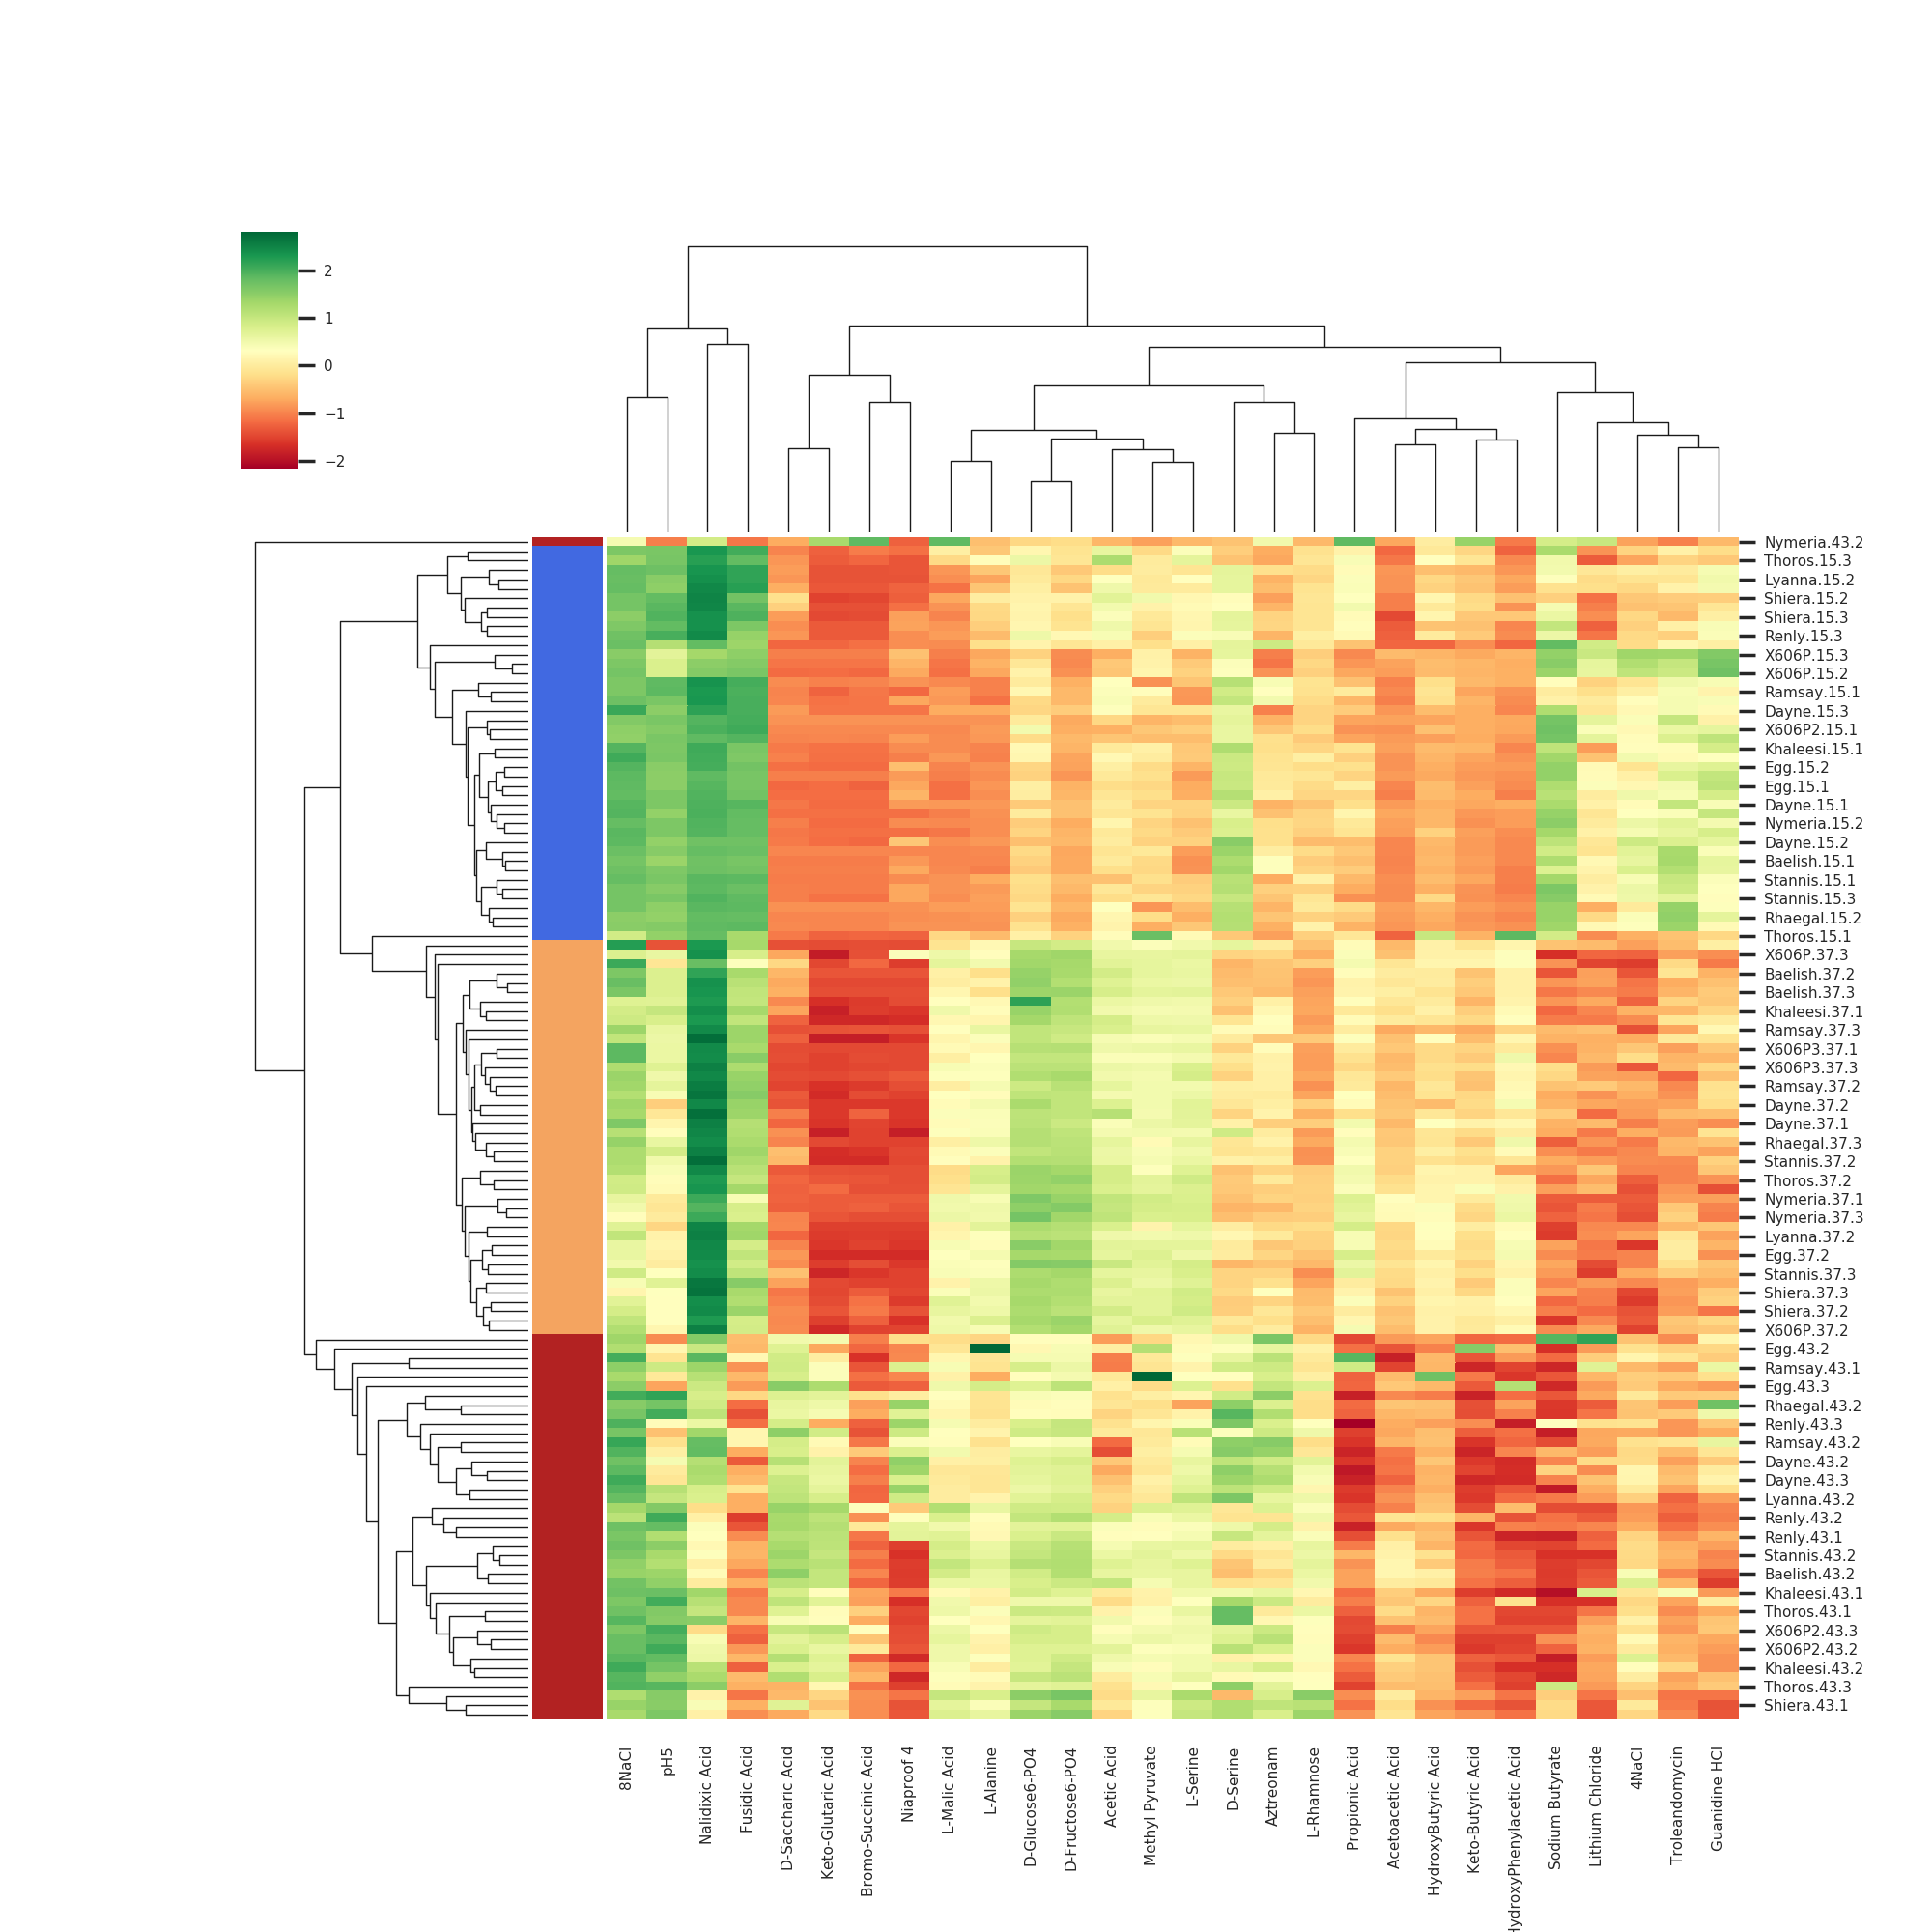

In [22]:
%matplotlib notebook
#Inspect each PC and look at the top wells, cluster them and inspect treatment
loadings = np.absolute(pca.components_)
percent=int(floor(0.7*len(loadings[1])))
order=np.argsort(loadings[1])
pc1=data.iloc[:,order[percent:len(loadings[1])]]
pc1=pc1.set_index(labels)
#Color by factor
colors1 = ['royalblue', 'sandybrown', 'firebrick']
y1= pd.Series(temperature, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)
#We can see how these variables effectively cluster our data
sns.set(font_scale=0.5) 
sns.clustermap(pc1,cmap="RdYlGn",row_colors=colors.values,z_score=0)
#Save
pp = PdfPages('pc2_clust_606.pdf')
plt.savefig(pp,format='pdf')
pp.close()

<IPython.core.display.Javascript object>


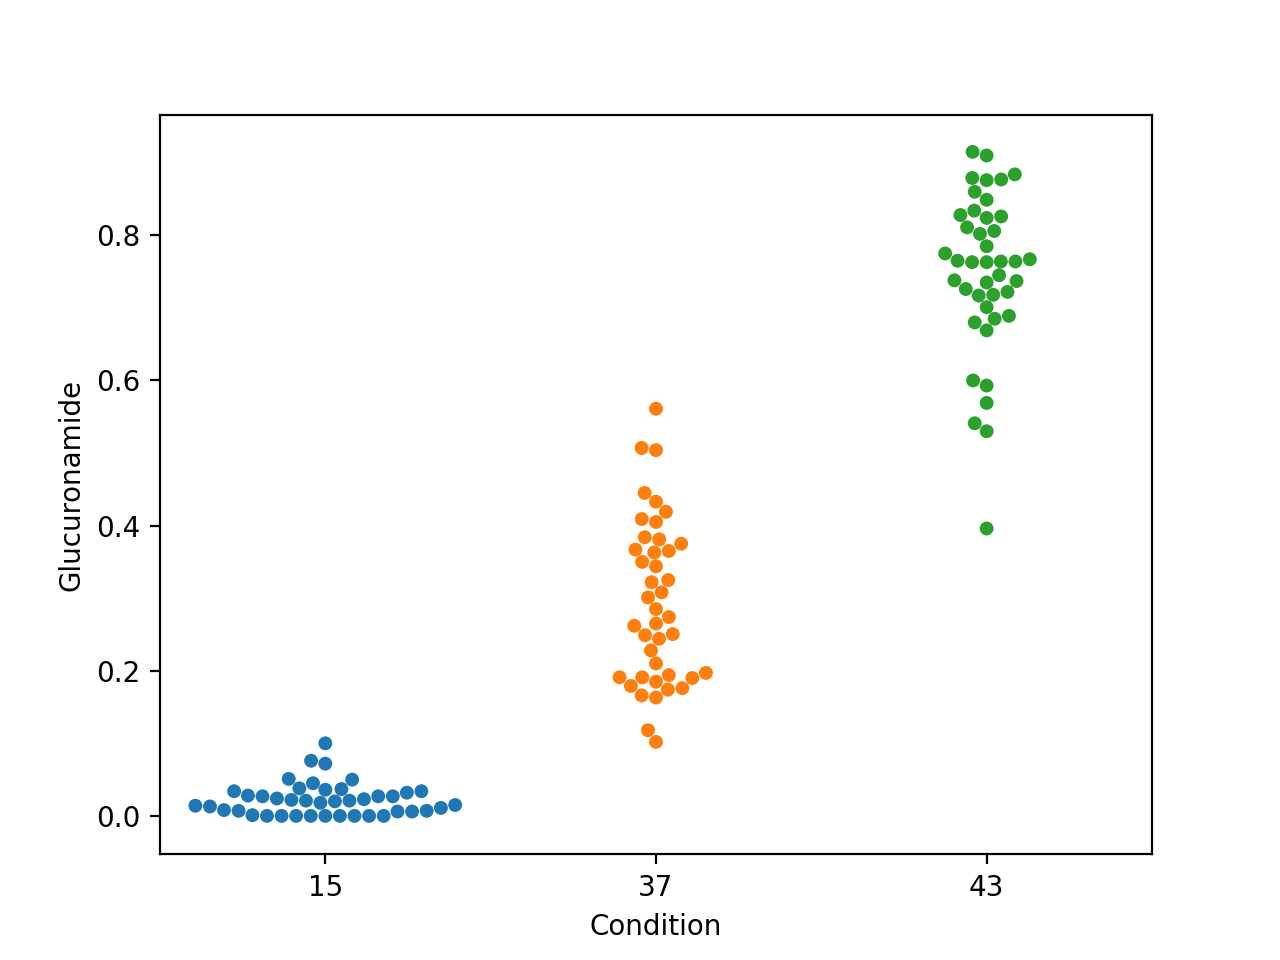

In [6]:
%matplotlib notebook
sns.swarmplot(x='Condition',y='Glucuronamide',data=df)

In [16]:
%matplotlib notebook
#Inspect each PC and look at the top wells, cluster them and inspect treatment
loadings = np.absolute(pca.components_)
percent=int(floor(0.9*len(loadings[4])))
order=np.argsort(loadings[4])df.Condition.values
pc1=data.iloc[:,order[percent:len(loadings[4])]]
pc1=pc1.set_index(labels)
#Color by factor
colors1 = ['royalblue', 'sandybrown', 'firebrick']
y1= pd.Series(df.Evolved.values, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)
#We can see how these variables effectively cluster our data
sns.set(font_scale=0.3) 
sns.clustermap(pc1,cmap="RdYlGn",row_colors=colors.values,z_score=0)
#Save
pp = PdfPages('pc2_clust_606.pdf')
plt.savefig(pp,format='pdf')
pp.close()

SyntaxError: invalid syntax (<ipython-input-16-4b7c1ea08ffd>, line 5)

In [ ]:
#Save loadings for the first PCs
wells=list(data)
pc1_load=pd.DataFrame({'wells': wells, 'loadings': loadings[0]})
pc1_load.to_csv('pc1_loadings_606.csv')
pc2_load=pd.DataFrame({'wells': wells, 'loadings': loadings[1]})
pc2_load.to_csv('pc2_loadings_606.csv')
pc3_load=pd.DataFrame({'wells': wells, 'loadings': loadings[2]})
pc3_load.to_csv('pc3_loadings_606.csv')
pc4_load=pd.DataFrame({'wells': wells, 'loadings': loadings[3]})
pc4_load.to_csv('pc4_loadings_606.csv')
pc5_load=pd.DataFrame({'wells': wells, 'loadings': loadings[4]})
pc5_load.to_csv('pc5_loadings_606.csv')

Isomap embedding

In [ ]:
%matplotlib notebook
from sklearn import manifold, datasets
n_neighbors=4
n_components=2
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
Y_anc = Y[0:17,:]
#Color by factor
colors1 =  ['royalblue','sandybrown', 'firebrick']
y1= pd.Series(df.Condition.values, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)
plt.scatter(Y[:, 0], Y[:, 1], c=colors, alpha=0.5)
plt.scatter(Y_anc[:, 0], Y_anc[:, 1], c='black', alpha=0.9)

In [ ]:
%matplotlib notebook
from sklearn import manifold, datasets
n_neighbors=4
n_components=2
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
Y_anc = Y[0:17,:]
#Color by factor
colors1 =  ['gray','green', 'yellow','red','purple']
y1= pd.Series(df.Treatment, dtype="category")
lut = dict(zip(y1.unique(), colors1))
colors=y1.map(lut)
plt.scatter(Y[:, 0], Y[:, 1], c=colors, alpha=0.5)
plt.scatter(Y_anc[:, 0], Y_anc[:, 1], c='black', alpha=0.9)

In [7]:
#Save scores
scores=pd.DataFrame(X_reduced)
scores=pd.concat([df.iloc[:,0:5],scores],axis=1)
scores.to_csv("606_scores.csv")